In [9]:
#importing the required modules
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
from tqdm import tqdm, notebook
notebook.tqdm().pandas()

In [10]:
# Small adjustments to default style of plots, making sure it's readable and colorblind-friendly everywhere
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size' : 12.5,
                     'figure.figsize':(25,7)})

Get the path to retrieve data from local folder

In [11]:
#Jules: 
#Small sample
path = r'/Users/jules/kDrive/onedrive/Documents_Onedrive/EPFL/MA3/ADA/Project/Dataset/'

#Big sample
#path = r'C:\Users\jules\kDrive\onedrive\Documents_Onedrive\EPFL\MA3\ADA\Project\Dataset\BIG_SAMPLE'

#### Using the provided csv file to link qids with meaningful names for speakers metadata

In [12]:
df_lookup = pd.read_csv('wikidata_labels_descriptions_quotebank.csv.bz2',compression = 'bz2',index_col='QID')

## Speakers_metadata

### Retrieve all americans politicians

In [13]:
#drop NaNs in occupation
def get_polUS(df_speakers):
    df_speakers.dropna(axis=0,inplace=True,subset=['occupation','nationality'])
    assert df_speakers['occupation'].isna().sum() == 0
    assert df_speakers['nationality'].isna().sum() == 0
    
    pol_cond = df_speakers['occupation'].apply(lambda x : any(item in 'Q82955' for item in x)) 
    us_cond = df_speakers['nationality'].apply(lambda x : any(item in 'Q30' for item in x)) #Q142 for french 

    df_polUS = df_speakers.loc[us_cond & pol_cond]

    return df_polUS


### Create the age column

In [107]:
from datetime import date, datetime

def get_age(df_speakers):
    
    #Define the function to calculate the age of speakers 
    def calculate_age(born):
        today = date.today()
        return today.year - born.year - ((today.month, today.day) < (born.month, born.day))
    
    def str2datetime(string):
        date_format = '+%Y-%m-%dT%H:%M:%SZ'
        try:
            dt = datetime.strptime(string,date_format)
        except:
            dt = None
        return dt
    
    df = df_speakers.copy()
    
    #Convert list into string
    df['date_of_birth'] = df['date_of_birth'].apply(lambda x: x[0] if x is not None else None)
    
    #Retrieve date_of_birth with 00-00 as month/day and replace it by the 01-01
    df['date_of_birth']=df['date_of_birth'].apply(lambda x: x.replace('-00','-01') if x is not None else None)

    #Transform date_of_birth from string to datetime
    df['date_of_birth'] = df['date_of_birth'].apply(lambda x: str2datetime(x)if x is not None else None)
    
    # Calculate the age of each speakers
    df['age'] =  df['date_of_birth'].apply(lambda x: calculate_age(x) if x else None)
    
    #Detect ages that are incoherent and drop the rows 
    
    df.drop(df[df['age']<15].index, inplace=True)
    df.drop(df[df['age']>110].index, inplace=True)
    
    return df

In [46]:
df_wt_age = get_age(df_polUS_2)

### Create a column containg either "Democrate" or "Republican" party

QID Republican : Q29468

QID Democratic Q29552

In [99]:
def get_bi_party(df_speakers):
    df = df_speakers.copy()
    
    demo_cond = df_speakers['party'].apply(lambda x : any(item in 'Q29552' for item in x) if x is not None else False)
    repu_cond = df_speakers['party'].apply(lambda x : any(item in 'Q29468' for item in x) if x is not None else False)
    
    df['bi_party']=None
    
    df.loc[demo_cond,'bi_party'] = 'Democrat'
    df.loc[repu_cond,'bi_party'] = 'Republican'
    
    return df

In [67]:
df_wt_biparty = get_bi_party(df_wt_age)

In [68]:
df_wt_biparty[['label','party','bi_party']]

,label,party,bi_party
0,Barack Obama,[Q29552],Democrat
1,Bernie Sanders,"[Q6542163, Q29552, Q327591, Q327591, Q29552]",Democrat
3,Hillary Clinton,"[Q29552, Q29468]",Republican
4,Andrew Cuomo,[Q29552],Democrat
6,Elizabeth Warren,[Q29552],Democrat
...,...,...,...
106506,Hans Zeiger,[Q29468],Republican
106634,Juan Babauta,[Q29468],Republican
106724,P. W. Singer,None,None
107202,George Ajjan,[Q29468],Republican


<AxesSubplot:>

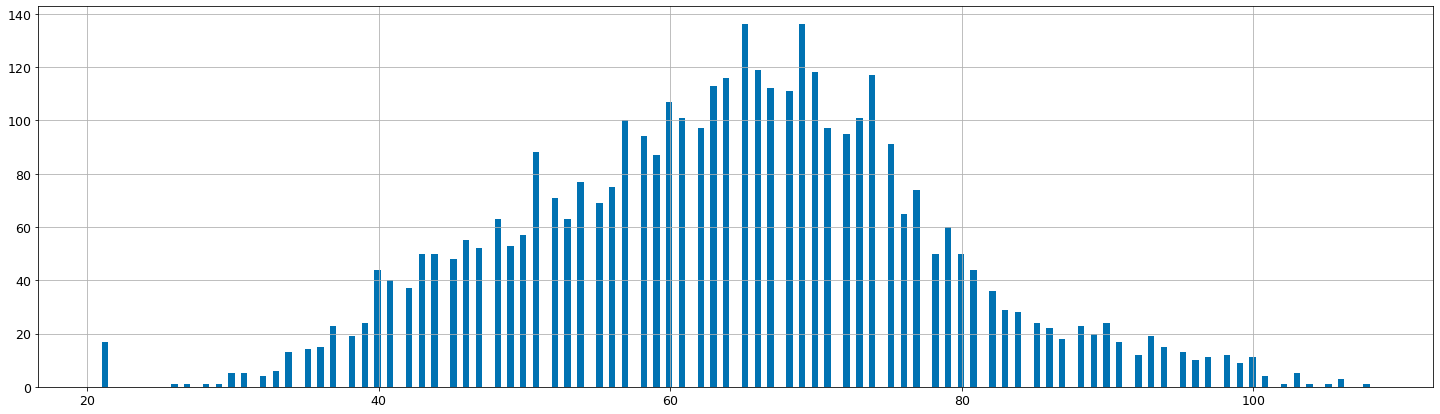

In [49]:
#Plot the distribution of ages 
df_wt_age['age'].hist(bins=200)

##  Create the dataset for linear regression 

In [118]:
def speakers_metadata(df_speakers):
    df = get_polUS(df_speakers)
    # shift column 'label' to first position
    first_column = df_pol.pop('label')
    # insert column using insert(position,column_name,first_column) function
    df_pol.insert(0, 'label', first_column)
    
    #Create the age column
    df = get_age(df_pol)
    
    #Create the bi-party column
    df = get_bi_party(df_pol)
    
    return df

In [126]:
def ready_for_lr(file_path,df_speakers):

    #Import quotes dataset (classified)
    df_quotes = pd.read_json(file_path,compression = 'bz2',lines = True)

    #Choose the first QID that is associated with (to be improved)
    df_quotes['qid_unique'] = df_quotes['qids'].apply(lambda x: x[0])

    #Drop the useless columns 
    col_useless = ['qids','probas','numOccurrences','phase']
    df_quotes.drop(col_useless,axis=1,inplace=True)
    
    # shift column 'label' to first position
    first_column = df_quotes.pop('qid_unique')
    # insert column using insert(position,column_name,first_column) function
    df_quotes.insert(3, 'qid_unique', first_column)
    
    #Merge the quote with the speakers metadata
    df_quotes_merged = df_quotes.merge(df_speakers,how='inner',left_on='qid_unique', right_on='id')
    
    return df_quotes_merged

In [74]:
#Get the speakers metadata
path = r'/Users/jules/kDrive/onedrive/Documents_Onedrive/EPFL/MA3/ADA/Project/Dataset/'
df_speakers = pd.read_parquet(path+'speaker_attributes.parquet')
df_speakers_pol=speakers_metadata(df_speakers)

In [ ]:
#Process the sample

path = r'/Users/jules/kDrive/onedrive/Documents_Onedrive/EPFL/MA3/ADA/Project/Dataset/BIG_SAMPLE/'
file_path = path+'Sample_2020_classified.json.bz2'

#path = r'/Users/jules/kDrive/onedrive/Documents_Onedrive/EPFL/MA3/ADA/Project/Dataset/'
#file_path = path+'Sample_classified_1Mio_v1.json'

df_speakers_pol = speakers_metadata(df_speakers)
df = ready_for_lr(file_path, df_speakers_pol)

In [124]:
df.columns

Index(['quoteID', 'quotation', 'speaker', 'qid_unique', 'date', 'urls', 'p1',
       'p2', 'delta_p', 'year', 'colloquial', 'label', 'aliases',
       'date_of_birth', 'nationality', 'gender', 'lastrevid', 'ethnic_group',
       'US_congress_bio_ID', 'occupation', 'party', 'academic_degree', 'id',
       'candidacy', 'type', 'religion', 'bi_party'],
      dtype='object')

In [30]:
df.to_json(path+'/Results/df_LR_2020.json.bz2',compression='bz2',lines=True,orient="records")

# 2. Aggretate quotes by each speaker

In [14]:
#Retrieve the dataset containing all speakers with the fraction of the colloquial language 
df_speakers =  pd.read_json(path+'Speakers_aggregation.json.bz2',compression = 'bz2',lines = True)

In [32]:
#Retrieve only the americans politicians 
df_polUS_2 = get_polUS(df_speakers)
df_polUS_2

,label,qid_unique,0,1,quotes_number,fraction,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,candidacy,type,religion
0,Barack Obama,Q76,1008,359,1367,0.262619,"[Barack Hussein Obama II, Barack Obama II, Bar...",[+1961-08-04T00:00:00Z],[Q30],[Q6581097],1395141963,"[Q49085, Q6935055, Q12826303, Q6392846]",O000167,"[Q82955, Q40348, Q15958642, Q28532974, Q372436]",[Q29552],"[Q1765120, Q1540185]",Q76,"[Q3586671, Q45578, Q4226, Q4791768, Q17067714,...",item,"[Q23540, Q1062789, Q960252, Q426316]"
1,Bernie Sanders,Q359442,723,268,991,0.270434,[Bernard Sanders],[+1941-09-08T00:00:00Z],[Q30],[Q6581097],1392561607,[Q7325],S000033,"[Q82955, Q1930187, Q154549, Q1622272, Q36180, ...","[Q6542163, Q29552, Q327591, Q327591, Q29552]",[Q1765120],Q359442,None,item,[Q9268]
3,Hillary Clinton,Q6294,645,245,890,0.275281,"[Hillary Rodham Clinton, Hillary Rodham, Hilla...",[+1947-10-26T00:00:00Z],[Q30],[Q6581072],1393846565,None,C001041,"[Q82955, Q40348, Q193391, Q36180, Q18814623, Q...","[Q29552, Q29468]","[Q163727, Q1540185]",Q6294,"[Q699872, Q4791768]",item,[Q33203]
4,Andrew Cuomo,Q11673,476,182,658,0.276596,[Andrew Mark Cuomo],[+1957-12-06T00:00:00Z],[Q30],[Q6581097],1393197828,[Q974693],None,"[Q40348, Q82955]",[Q29552],[Q1540185],Q11673,"[Q22023432, Q65047185]",item,[Q1841]
6,Elizabeth Warren,Q434706,378,179,557,0.321364,"[Elizabeth Ann Warren, Senator Warren, Elisabe...",[+1949-06-22T00:00:00Z],[Q30],[Q6581072],1394365746,[Q49078],W000817,"[Q185351, Q82955, Q37226, Q1622272, Q40348, Q1...",[Q29552],"[Q163727, Q1540185]",Q434706,[Q28220813],item,[Q33203]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106506,Hans Zeiger,Q3127030,1,0,1,0.000000,None,[+1985-02-20T00:00:00Z],[Q30],[Q6581097],1392052490,None,None,"[Q82955, Q1930187]",[Q29468],None,Q3127030,None,item,None
106634,Juan Babauta,Q3187744,1,0,1,0.000000,"[Juan N. Babauta, Juan Nekai Babauta]",[+1953-09-07T00:00:00Z],[Q30],[Q6581097],1396092459,None,None,[Q82955],[Q29468],None,Q3187744,None,item,[Q1841]
106724,P. W. Singer,Q320696,1,0,1,0.000000,[Peter Warren Singer],[+1974-01-01T00:00:00Z],[Q30],[Q6581097],1393157459,None,None,"[Q1238570, Q82955]",None,[Q849697],Q320696,None,item,None
107202,George Ajjan,Q3101374,0,1,1,1.000000,None,[+1976-07-05T00:00:00Z],[Q30],[Q6581097],1392802317,None,None,[Q82955],[Q29468],None,Q3101374,None,item,None


### Plot the distribution of colloquial language speaker in political party

[Text(0, 0.5, 'Average fraction of colloquial quotations')]

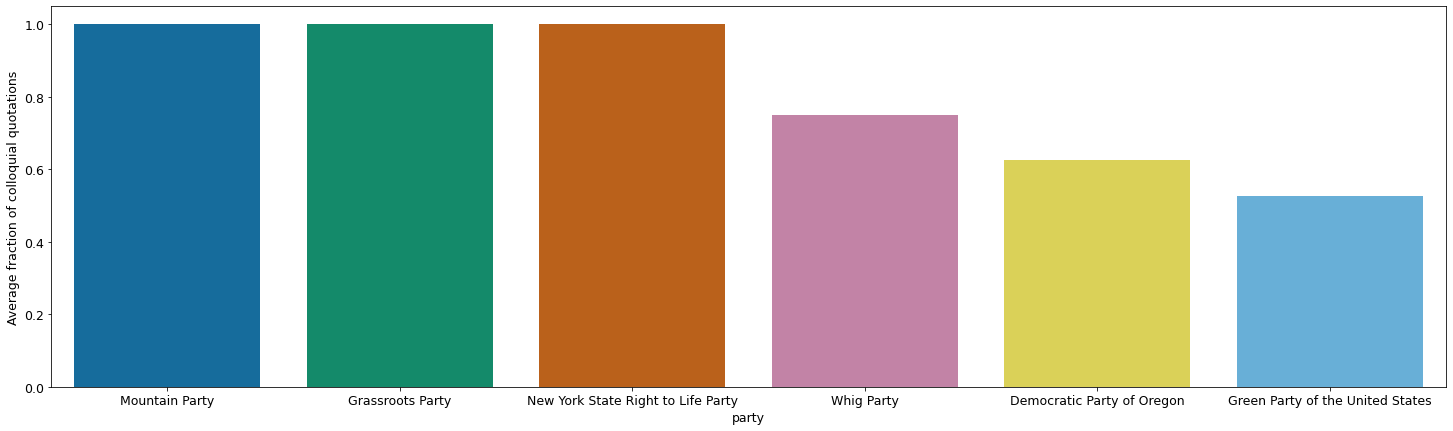

In [18]:

df_party=df_polUS_2.copy()
#Replace label column at the first place to see speakers names
df_party.dropna(axis = 0, subset=['party'], inplace=True)

#Drop all speakers that several parties
oneparty_cond = df_party['party'].apply(lambda x: len(x)==1)

#Transforma a list into one element
df_party['party'] = df_party['party'].apply(lambda x: x[0]) 

df_party = df_party[oneparty_cond]

#Not taking in account the occupation with fraction equals to 1 (correspond to speakers with not sufficient amount of quotations)
df_plot = df_party.groupby('party')['fraction'].mean() \
           .reset_index(name='mean_fraction')\
            .sort_values(['mean_fraction'], ascending=False)
#Not taking in account the occupation with fraction equals to 1 (correspond to speakers with not sufficient amount of quotations)

#df_plot = df_plot[df_plot['mean_fraction']!=1]
df_plot['party'] = df_plot['party'].apply(lambda x: df_lookup.loc[x]['Label'])

ax = sns.barplot(x='party', y="mean_fraction", data=df_plot[:6])
ax.set(ylabel='Average fraction of colloquial quotations')

In [19]:
print("There are {} parties in our dataset".format(len(df_plot)))

There are 62 parties in our dataset
